In [8]:

import matplotlib.pyplot as plt
import np as np
import numpy as np
import pandas as pd
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

!pip install numpy scipy scikit-learn matplotlib pandas
from sklearn.model_selection import GridSearchCV

You should consider upgrading via the '/Users/engineer/workspace/cse590-machine-learning/venv/bin/python -m pip install --upgrade pip' command.


In [17]:
X = pd.read_csv("../dataset/extracted_features.csv").values
y = pd.read_csv("../dataset/labels.csv").values.ravel()
# images = pd.read_csv("../dataset/raw_images.csv").values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
y_train = y_train.ravel()

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X)
X_robust = scaler_robust.transform(X)

scaler_minmax = MinMaxScaler().fit(X)
X_minmax = scaler_minmax.transform(X)

In [5]:
for i in range(9):
    print(np.count_nonzero(y==i))

325
99
133
154
281
283
325
318
301


In [7]:
cov_mat = np.cov(X_train_standard)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:,np.newaxis], eigen_pairs[1][1][:,np.newaxis]))
# X_train_pca = X_standard.dot(w)


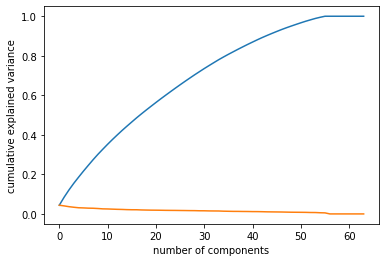

In [23]:
pca = PCA().fit(X_train_standard)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [25]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.04396581 0.08454001 0.12117899 0.15489076 0.18607458 0.21642915
 0.24557428 0.2742422  0.3015467  0.32713522 0.35220294 0.37634953
 0.39958237 0.42221944 0.44388931 0.46502977 0.48606358 0.5061346
 0.52566572 0.54472169 0.5635908  0.58212527 0.60024165 0.61809383
 0.6357942  0.65315314 0.67026621 0.68698953 0.70355913 0.71947453
 0.73530084 0.75049762 0.76545234 0.78023516 0.79403574 0.80738257
 0.82024602 0.83302449 0.84540329 0.85760931 0.86936663 0.88101555
 0.89220348 0.90275081 0.91297715 0.92292382 0.93258715 0.94169533
 0.95028869 0.95866363 0.96681103 0.97468158 0.98185357 0.98887549
 0.99475194 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


AttributeError: 'PCA' object has no attribute 'explained_variance_ratio'

56 features = 100
36 = .807

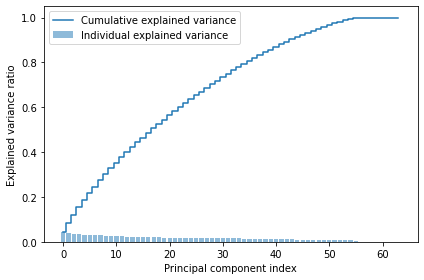

In [26]:
#
# Scale the dataset; This is very important before you apply PCA
#
from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_standard)

#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()